<h1 style='text-align:center'>Convolutional Neural Networks</h1>

### What are CNNs used for?

In [ ]:
from IPython.display import IFrame
IFrame(src="https://www.youtube.com/embed/ACmydtFDTGs", width='622', height='466')

CNNs are mainly used for image recognition/classification. They can be used for video analysis, NLP (sentiment analysis, topic modeling), and speech recognition. Today we'll be discussing how CNNs are you used to classify images. 

### How do our brains see an image? 


We might see some fluffy tail, a wet nose, flappy ears, and a good boy and conclude we are probably seeing dog. There is not one singular thing about a dog that our brain recognizes as a dog but an amalgamation of different patterns that allow us to make a probable guess.  


<img src='./img/chihuahua.jpeg'/>

### Convolutal Neural Networks - How computers see images

<img src='./img/architecture.jpeg'/>

###### Images

To computers images are a 3D object - composed of 3 matrices - one for each primary color that can be combined in varying intensities to create different colors. Each element in a matrix represents the location of a pixel and contains a number between 0 and 255 which indicates the intensity of the corresponding primary color in that pixel. 

##### From wikipedia:

    "The RGB color model is an additive color model[1] in which red, green and blue light are added together in various ways to reproduce a broad array of colors. The name of the model comes from the initials of the three additive primary colors, red, green, and blue. The main purpose of the RGB color model is for the sensing, representation, and display of images in electronic systems, such as televisions and computers"

<img src='./img/rgb.png'/>

### Why do we want CNNs

![](./img/NN_vs_CNN.png)

![](./img/weight_sharing_1.png)

### Convolution

<b>To Convolve means to roll together</b><br/><br/>
In the context of mathematics think of it as a way of mixing two functions by multiplying them.<br/><br/>

Convolutional neural networks make use of linear algebra to identify patterns using the pixel values (intensity of R,G, or B). By taking a small matrix and moving it across an image and multiplying them together every time it moves our network can mathematically identify patterns in these images. This small matrix is known as a <b>"kernel"</b> or <b>"filter"</b> and each one is designed to identify a particular pattern in an image (edges, shapes, etc.)

<img src='./img/convolve.gif' width='300px'/>

![](./img/conv.gif)

When a filter is "rolled over" an image the resulting matrix is called a <b>Feature Map</b> - literally a map of where each pattern of feature is in the image. Elements with higher values indicate the presence of that pattern the filter is looking. 

The values (or weights) of the filter are adjusted during back-propagation.

Every node in a neural network layer is a different filter looking for a certain pattern. 

##### Typically use 3X3 maps

##### For N⨉N input and kernel size k⨉k the output size is M = N - k + 1

<h3>Parameters</h4>

<b>Padding</b> - Sometimes it is convenient to pad the input volume with zeros around the border. Helps with detecting patterns at the edge of an image. 

- Padding 'SAME' - keeps image the same size (k-1/2 on each side for map sized k) 
- Padding 'VALID' - padding is 0.

Padding is used to control resolution in the output layer!

<b>Stride</b> - The number of pixels to shift the filter on each "roll". The larger the stride the smaller the feature map will be - but we will lose more information.

Used for:
 - faster processsing
 - invariance to translation
 
$Output = \frac{I + 2pad - map}{stride} + 1$

### Pooling

The feature maps are fed into a max pool layer, and like convolutions, this method is applied one patch at a time (usually 2x2). Max pooling simply takes the largest value from one patch of an image, places it in a new matrix next to the max values from other patches, and discards the rest of the information contained in the activation maps. Other methods exist such as average pooling (taking an average of the patch). 

<img src='./img/maxpool.png'/>


This process results in a new feature map with reduced dimensionality that is then passed into another convolution layer to continue the pattern finding process. These steps are repeated until they are passed to a fully connected layer that proceeds to classify the image using the identified patterns. 

Used for:
    - invarince for translation
    - faster processing 

### Dilation

Use for high resolution to reduce complexity

$Output = \frac{I + 2pad - map'}{stride} + 1$

$map' = map + (map-1)*(dilate - 1)$

### Classification

Once the neural networks has collected a series of patterns that an image contains it is ready to make a guess as to what the image is. In order to do so, it starts by flattening the 2D matrix into a 1D vector, so it can be passed into a normal densely connected layer for classification. Then using this vector one or many densely connected layers will make a prediction as to what the image is. 

<img src="img/typical_CNN.png" width=150>

### Transfer Learning

Transfer learning is the process of training the last few layers of a pre-trained model to make classifications for a specific use case. This is not exclusive to CNNs but can be applied other neural networks and ML models. Pre-trained CNN models have dozens to hundreds of layers that have been trained on millions of images. Through this training they are very good at identifying complex patterns in image and these collection of patterns can then be used to train the final densely connected layers to make a specific classification. Examples of these pre-trained models include ResNet, InceptionNet, VGG16 - many of which are available through Keras. 

### Code 

In [1]:
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
import keras
from keras import models
from keras import layers
from sklearn.metrics import confusion_matrix, f1_score
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

np.random.seed(123)

Using TensorFlow backend.


## Load Training Data

In [ ]:
# download from https://www.kaggle.com/dansbecker/hot-dog-not-hot-dog/download
!unzip data/hot-dog-not-hot-dog.zip -d data/

## Preprocess Images

In [2]:
# get all the data in the directory split/test, and reshape them
data_te = ImageDataGenerator(rescale=1./255).flow_from_directory(
    'data/test',
    target_size=(224, 224),
    batch_size=4419,
    seed=123)

Found 500 images belonging to 2 classes.


In [3]:
data_tr = ImageDataGenerator(rescale=1./255).flow_from_directory(
    'data/train',
    target_size=(224, 224),
    batch_size=4419,
    seed=123)

Found 498 images belonging to 2 classes.


In [4]:
#split images and labels
images_tr, labels_tr = next(data_tr)

In [5]:
images_tr.shape

(498, 224, 224, 3)

In [6]:
#split images and labels
images_te, labels_te = next(data_te)

In [7]:
images = np.concatenate((images_tr, images_te))

In [8]:
labels = np.concatenate((labels_tr[:,0], labels_te[:,0]))

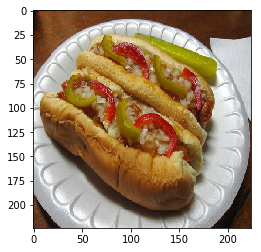

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(images[10])
plt.show()

## 3. Convolutional neural network

In [10]:
from sklearn.model_selection import train_test_split
X_model, X_test, y_model, y_test = train_test_split(images, labels, test_size=0.20, random_state=123)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=0.20, random_state=123)

In [12]:
cnn = models.Sequential()
cnn.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224,  3), padding='SAME'))
# 64 bias parameters
# 64 * (3 * 3 * 3) weight parametrs
# Output is 64*224*224
cnn.add(layers.MaxPooling2D((2, 2)))
# Output is 64*112*112
cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
# 32 bias parameters
# 32 * (3*3*64)
# Output is 32*112*112 
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(32, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))

cnn.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

W1008 15:09:58.223983 4429833664 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W1008 15:09:58.323482 4429833664 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
saving_weights = keras.callbacks.ModelCheckpoint(
    'weights.{epoch:02d}-{val_loss:.2f}.hdf5',
    monitor='val_loss', verbose=0, save_best_only=False,
    save_weights_only=False, mode='auto', period=10
)

In [14]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=20,
    verbose=0, mode='auto', min_delta=0.0001, min_lr=0)

In [15]:
nan_problem = keras.callbacks.TerminateOnNaN()

In [16]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=20,
    verbose=0, mode='auto', baseline=None, restore_best_weights=False)


In [17]:
csv_logger = keras.callbacks.CSVLogger('training.log')


In [18]:
print(cnn.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 32)      18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 96800)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                3097632   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [19]:
cnn1 = cnn.fit(X_train,
               y_train,
               epochs=10,
               batch_size=200,
               validation_data=(X_val, y_val),
               callbacks=[csv_logger, early_stop, nan_problem, reduce_lr, saving_weights])

W1008 15:10:35.331103 4429833664 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 638 samples, validate on 160 samples
Epoch 1/10
638/638 [==============================] - 29s 45ms/step - loss: 0.6922 - acc: 0.5235 - val_loss: 0.6931 - val_acc: 0.5688
Epoch 2/10
638/638 [==============================] - 20s 31ms/step - loss: 0.6996 - acc: 0.4953 - val_loss: 0.6961 - val_acc: 0.4750
Epoch 3/10
638/638 [==============================] - 20s 31ms/step - loss: 0.6865 - acc: 0.5345 - val_loss: 0.6919 - val_acc: 0.5437
Epoch 4/10
638/638 [==============================] - 20s 31ms/step - loss: 0.6846 - acc: 0.5752 - val_loss: 0.7083 - val_acc: 0.4313
Epoch 5/10
638/638 [==============================] - 19s 30ms/step - loss: 0.6817 - acc: 0.5596 - val_loss: 0.6970 - val_acc: 0.4563
Epoch 6/10
638/638 [==============================] - 19s 30ms/step - loss: 0.6864 - acc: 0.5580 - val_loss: 0.6906 - val_acc: 0.5688
Epoch 7/10
638/638 [==============================] - 23s 35ms/step - loss: 0.6878 - acc: 0.5893 - val_loss: 0.7280 - val_acc: 0.4313
Epoch 8/10
638/6

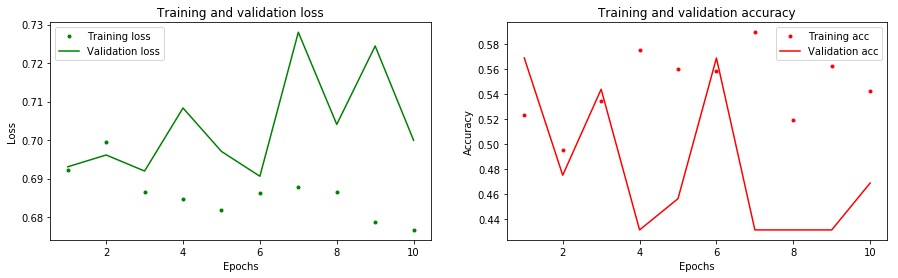

In [22]:
hist_cnn = cnn1.history
loss_values = hist_cnn['loss']
val_loss_values = hist_cnn['val_loss']
acc_values = hist_cnn['acc']
val_acc_values = hist_cnn['val_acc']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g.', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'r.', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
results_train = cnn.evaluate(X_train, y_train)
results_test = cnn.evaluate(X_test, y_test)
print(results_train, results_test)

200/200 [==============================] - 2s 8ms/step
[0.6697195486215215, 0.5799372792243958] [0.6828210735321045, 0.5550000071525574]


In [ ]:
# This should load a weight file in, but I can't seem to figure out how to make this work
# cnn.load_weights("weights.20-0.75.hdf5")

In [ ]:
# cnn.evaluate(X_val, y_val)

## Transfer Learning

### InceptionNet

In [24]:
from keras.applications import inception_v3
from keras.layers import Dense,GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix, f1_score
from keras.models import Model

In [25]:
imagenet=inception_v3.InceptionV3(weights='imagenet',include_top=False)
imagenet_new=imagenet.output
new_model = models.Sequential()
new_model.add(imagenet)
new_model.add(GlobalAveragePooling2D())
new_model.add(Dense(1024,activation='relu'))
new_model.add(Dense(1024,activation='relu')) #dense layer 2
new_model.add(Dense(512,activation='relu')) #dense layer 3
new_model.add(Dense(1,activation='sigmoid')) #final layer with softmax activation

W1008 15:29:01.243215 4429833664 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4074: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



In [26]:
for i, layer in enumerate(imagenet.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 conv2d_3 True
2 batch_normalization_1 True
3 activation_1 True
4 conv2d_4 True
5 batch_normalization_2 True
6 activation_2 True
7 conv2d_5 True
8 batch_normalization_3 True
9 activation_3 True
10 max_pooling2d_3 True
11 conv2d_6 True
12 batch_normalization_4 True
13 activation_4 True
14 conv2d_7 True
15 batch_normalization_5 True
16 activation_5 True
17 max_pooling2d_4 True
18 conv2d_11 True
19 batch_normalization_9 True
20 activation_9 True
21 conv2d_9 True
22 conv2d_12 True
23 batch_normalization_7 True
24 batch_normalization_10 True
25 activation_7 True
26 activation_10 True
27 average_pooling2d_1 True
28 conv2d_8 True
29 conv2d_10 True
30 conv2d_13 True
31 conv2d_14 True
32 batch_normalization_6 True
33 batch_normalization_8 True
34 batch_normalization_11 True
35 batch_normalization_12 True
36 activation_6 True
37 activation_8 True
38 activation_11 True
39 activation_12 True
40 mixed0 True
41 conv2d_18 True
42 batch_normalization_16 True
43 activation_16 True
44 c

In [27]:
for i,layer in enumerate(new_model.layers):
    print(i,layer.name, layer.trainable)

0 inception_v3 True
1 global_average_pooling2d_1 True
2 dense_3 True
3 dense_4 True
4 dense_5 True
5 dense_6 True


In [28]:
for layer in new_model.layers[:1]:
    layer.trainable=False

In [29]:
for i,layer in enumerate(new_model.layers):
    print(i,layer.name, layer.trainable)

0 inception_v3 False
1 global_average_pooling2d_1 True
2 dense_3 True
3 dense_4 True
4 dense_5 True
5 dense_6 True


In [30]:
new_model.compile(optimizer='Adam',
                  loss='binary_crossentropy', metrics=['accuracy'])

# step_size_train=train_generator.n//train_generator.batch_size
new_model.fit(X_train,
              y_train,
              epochs=10,
              batch_size=50,
              validation_data=(X_val, y_val))

Train on 638 samples, validate on 160 samples
Epoch 1/10
638/638 [==============================] - 28s 44ms/step - loss: 0.8023 - accuracy: 0.6050 - val_loss: 0.2989 - val_accuracy: 0.8813
Epoch 2/10
638/638 [==============================] - 27s 42ms/step - loss: 0.4738 - accuracy: 0.7759 - val_loss: 1.7326 - val_accuracy: 0.5688
Epoch 3/10
638/638 [==============================] - 28s 43ms/step - loss: 0.3531 - accuracy: 0.8464 - val_loss: 0.5540 - val_accuracy: 0.8250
Epoch 4/10
638/638 [==============================] - 30s 47ms/step - loss: 0.3633 - accuracy: 0.8464 - val_loss: 0.3004 - val_accuracy: 0.8750
Epoch 5/10
638/638 [==============================] - 32s 50ms/step - loss: 0.3643 - accuracy: 0.8292 - val_loss: 0.3747 - val_accuracy: 0.8500
Epoch 6/10
638/638 [==============================] - 29s 46ms/step - loss: 0.2360 - accuracy: 0.9028 - val_loss: 0.8310 - val_accuracy: 0.8188
Epoch 7/10
638/638 [==============================] - 25s 40ms/step - loss: 0.1848 - accur

In [31]:
new_model.evaluate(X_test, y_test)

200/200 [==============================] - 7s 36ms/step


[0.6236589443683624, 0.8849999904632568]

In [32]:
predictions_transfer = new_model.predict(X_test)
predictions_transfer = np.around(predictions_transfer)

In [ ]:
f1_score(y_test, predictions_transfer)

In [ ]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, predictions_transfer), classes=['hot dog', 'not hot dog'], normalize=False,
                      title='Confusion matrix - ImagenetV3')

In [ ]:
def predictoneimage_cnn(model, path):
    img = load_img(path, target_size=(224, 224))
    plt.imshow(img)
    img = img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)
    predict = model.predict(img)
    return predict

In [ ]:
predictoneimage_cnn(new_model, '/content/hot-dog-not-hot-dog/test/not_hot_dog/13719.jpg')

##### Resources

https://skymind.ai/wiki/convolutional-network

https://cs231n.github.io/convolutional-networks/

